In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from IPython.display import display
import yaml

In [2]:
conf = yaml.load(
    open("credentials.yml"), Loader=yaml.FullLoader)['pg']

# Create a connection to the database
conn = psycopg2.connect(
    host=conf['host'],
    port=conf['port'],
    database=conf['database'],
    user=conf['user'],
    password=conf['password']
)

A simple query can be executed either with native psycopg's framework or instanvia pandas.
As an example let's get a total number of sessions in the database

In [3]:
q = "select count(*) as n_sessions from connector_user_sessions"
df = pd.read_sql(q, conn)
print(df)

   n_sessions
0     8961277


### Distributions

One of the basic usages of the data would be to view the data distributions
and to learn the main statistical properties such as mean, median, variance etc
which eventually lead to understanding your users better.
Visualization examples in this document include:
- Session durations
- User locations
- Website load (seasonality)
- Histogram of issue counts
- Hesitation time distribution
- URL visits graph

##### Session duration

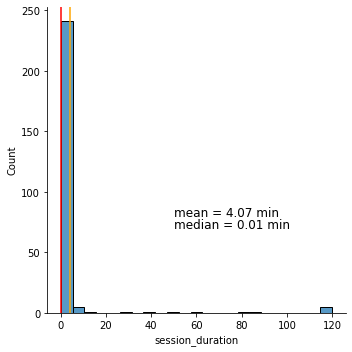

In [4]:
q = 'select session_duration from connector_user_sessions limit 10000'
durations = pd.read_sql(q, conn)

# translate duration to seconds
durations['session_duration'] = durations['session_duration'] / (1000 * 60)
sns.displot(durations, x="session_duration", bins=23)
x_mean =durations['session_duration'].mean()
x_median =durations['session_duration'].median()

plt.axvline(x_mean, c='orange')
plt.axvline(x_median, c='red')
plt.text(50, 80, f"mean = {x_mean:.2f} min", size=12)
plt.text(50, 70, f"median = {x_median:.2f} min", size=12)
plt.show()

##### User locations

In [5]:
q = 'select count(*) as n_users, user_country from connector_user_sessions group by user_country '
countries = pd.read_sql(q, conn)
countries  = countries[countries['n_users'] > 900]

In [6]:
coordinates = pd.read_csv('coordinates_and_codes.csv')
countries_with_coords = pd.merge(countries, coordinates, left_on='user_country', right_on='alpha-2_code')
countries_with_coords.drop(['alpha-2_code'], axis=1, inplace=True)
print(countries_with_coords.head())

   n_users user_country  latitude  longitude
0     1567           AU     -27.0      133.0
1    31726           BR     -10.0      -55.0
2     5181           CA      60.0      -95.0
3     1183           CH      47.0        8.0
4     1013           CO       4.0      -72.0


In [7]:
import folium

m = folium.Map(location=[40.18130, 44.5089], zoom_start=1, prefer_canvas=True)

def plotDot(point):
    '''input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map'''
    folium.Marker(location=(point.latitude, point.longitude),
                        # radius=point.n_users,
                        color="#3186cc",
                        popup=point.n_users,
                        fill=True,
                        fill_color="#3186cc").add_to(m)
countries_with_coords.apply(plotDot, axis=1)
m.save('users_map.html')

display(m)



##### Website load

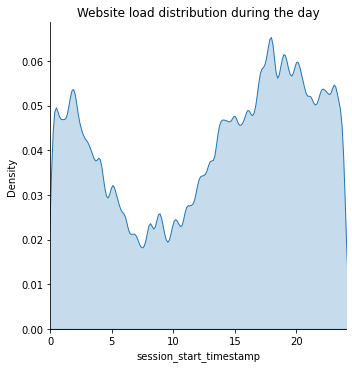

In [8]:
day = 86400 * 1000

q = 'select session_start_timestamp from connector_user_sessions where session_start_timestamp is not null limit 10000'
starts = pd.read_sql(q, conn)
starts['session_start_timestamp'] = starts['session_start_timestamp'].apply(lambda x: (x % day)* 24 / day)
sns.displot(starts, x="session_start_timestamp", kind="kde", bw_adjust=.2, fill=True)
plt.xlim(0, 24)
plt.title("Website load distribution during the day")
plt.show()

##### Issue counts

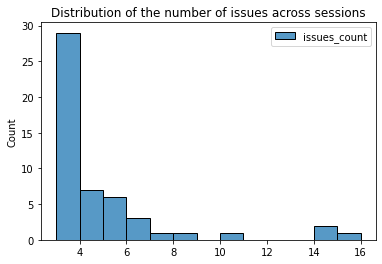

In [9]:
q = 'select issues_count from connector_user_sessions limit 10000'
issues = pd.read_sql(q, conn)
issues = issues.fillna(0)
sns.histplot(issues[issues > 2])
plt.title("Distribution of the number of issues across sessions")
plt.show()



##### Hesitation time distribution

In [10]:
q = "select mouseclick_hesitationtime from connector_events where mouseclick_label = 'PAY' " \
    "and mouseclick_hesitationtime is not null limit 10000"

hesitation = pd.read_sql(q, conn)
print(hesitation.shape)


(43, 1)


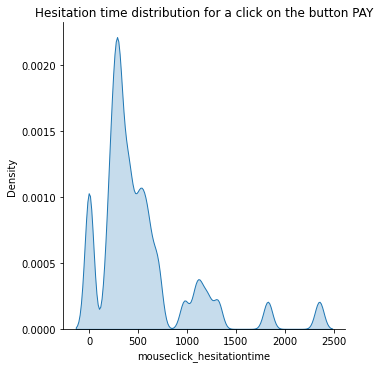

In [11]:
sns.displot(hesitation, x="mouseclick_hesitationtime", kind="kde", bw_adjust=.2, fill=True)
plt.title("Hesitation time distribution for a click on the button PAY")
plt.show()

##### Path illustration

In [12]:
# Select some session events. For illustration purposes, we stick to a fixed number of rows,
# however it would be more accurate to load all events for each session
q = 'select pageevent_url, sessionid from connector_events ' \
    'where pageevent_url is not null limit 100000'
urls = pd.read_sql(q, conn)

# Calculate the number of UNIQUE urls per session
urls_count = urls.groupby('sessionid').agg('nunique').reset_index()

# Select the session with the maximum number of UNIQUE urls
urls_count = urls_count.sort_values(by='pageevent_url', ascending=False)
urls_count.head()

,sessionid,pageevent_url
9036,4169875804784252,231
134,4167791269614996,229
7115,4169433581028977,136
24174,4176629796934961,107
18942,4172534204991174,104


In [16]:
# Get all url visits in correct order
# (to visualize the full path, not only unique values matter)
sess_id = urls_count.iloc[0].sessionid
sess_id = 4592792577630589
q = f'select pageevent_url from connector_events ' \
    f'where sessionid = {sess_id} ' \
    f'and pageevent_url is not null limit 1000'

session_urls = pd.read_sql(q, conn)

In [17]:
# We consider URLs with different query parameters to be the same
# by cutting off the part after question mark:

session_urls['pageevent_url'] = session_urls['pageevent_url'].apply(lambda x: x.split('?')[0])
session_urls.head()

,pageevent_url
0,https://atlas.cradle.global/briefs/list
1,https://atlas.cradle.global/briefs/view/6adf82...
2,https://atlas.cradle.global/briefs/view/6adf82...
3,https://atlas.cradle.global/briefs/list
4,https://atlas.cradle.global/briefs/view/e2b0f0...


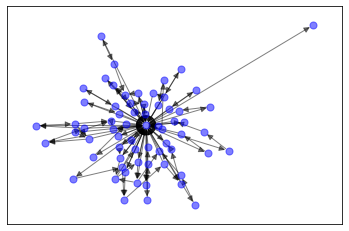

In [18]:
# For the "largest" session draw a graph of page visits
import networkx as nx

G = nx.DiGraph(directed=True)

for ind in range(session_urls.pageevent_url.shape[0] - 1):
    G.add_edges_from([(session_urls.pageevent_url[ind], session_urls.pageevent_url[ind + 1])])

options = {
    'node_color': 'blue',
    'node_size': 50,
    'width': 1,
    'alpha': 0.5,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}

nx.draw_networkx(G, arrows=True, with_labels=False, **options)


Analysis of such graphs may be useful in user profiling.
The graph of page visits can provide essential information to clusterize users by their behavior
even if they don't actions on the website.



